<font size="6">Project Name</font>
<br>
<font size="3">Project Description. </font>
<br>
<br>
<font size="3">1. Business Task 1 </font>
<br>
<font size="3">2. Business Task 2 </font>
<br>
<font size="3">3. Business Task 3 </font>

In [1]:
pip install ipython-sql

Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext sql

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [18]:
import os
import pandas as pd
import numpy as npy
import matplotlib.pyplot as plt
from tabulate import tabulate
import sqlite3

<font size="3">Convert CSV(s) to SQL tables</font>

In [159]:
# Directory containing your CSV files
csv_directory = '/Users/leahbowers/Portfolio/Spotify/'

# SQLite database file
db_file = 'spotify.db'

# Create a SQLite database connection
conn = sqlite3.connect(db_file)

# Iterate through CSV files in the directory
for csv_file in os.listdir(csv_directory):
    if csv_file.endswith('.csv'):
        file_path = os.path.join(csv_directory, csv_file)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path, encoding='latin1')
        
        # Replace spaces and special characters in column names with underscores
        df.columns = [c.replace(' ', '_').replace('.', '_').replace('-', '_') for c in df.columns]
        
        # Determine the table name (use the file name without extension)
        table_name = os.path.splitext(csv_file)[0]
        
        # Write the DataFrame to the SQLite database as a new table
        df.to_sql(table_name, conn, if_exists='replace', index=False)

# Commit changes and close the database connection
conn.commit()
conn.close()

In [160]:
# Connect to project database
%sql sqlite:///spotify.db

In [178]:
# Check that table was converted from csv and pulled into database
conn = sqlite3.connect('spotify.db')
query = """
    SELECT 
        name 
    FROM sqlite_master 
    WHERE type='table';
"""
result = pd.read_sql_query(query, conn)
print(tabulate(result, headers='keys', tablefmt='psql', showindex=False))

+--------------+
| name         |
|--------------|
| spotify_2023 |
+--------------+


In [162]:
#Clean up Project database
conn = sqlite3.connect('spotify.db')

cursor = conn.cursor()
table_name_to_remove = 'spotify_2023_2'

drop_table_query = f"DROP TABLE IF EXISTS {table_name_to_remove};"
cursor.execute(drop_table_query)

conn.commit()
conn.close()

<font size="6">Introduction</font>

In [163]:
# Confirm data types are correct
conn = sqlite3.connect('spotify.db')
query = """
    PRAGMA table_info(spotify_2023)
"""
result = pd.read_sql_query(query, conn)
print(tabulate(result, headers='keys', tablefmt='psql', showindex=False))

+-------+----------------------+---------+-----------+--------------+------+
|   cid | name                 | type    |   notnull | dflt_value   |   pk |
|-------+----------------------+---------+-----------+--------------+------|
|     0 | track_name           | TEXT    |         0 |              |    0 |
|     1 | artist(s)_name       | TEXT    |         0 |              |    0 |
|     2 | artist_count         | INTEGER |         0 |              |    0 |
|     3 | released_year        | INTEGER |         0 |              |    0 |
|     4 | released_month       | INTEGER |         0 |              |    0 |
|     5 | released_day         | INTEGER |         0 |              |    0 |
|     6 | in_spotify_playlists | INTEGER |         0 |              |    0 |
|     7 | in_spotify_charts    | INTEGER |         0 |              |    0 |
|     8 | streams              | TEXT    |         0 |              |    0 |
|     9 | in_apple_playlists   | INTEGER |         0 |              |    0 |

In [164]:
#Get preview of spotify table
pd.set_option('display.max_columns',None)
spotify_2023 = pd.read_csv('/Users/leahbowers/Portfolio/Spotify/spotify_2023.csv', encoding='latin1')
spotify_2023.head(5)

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,263,45,10,826,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,126,58,14,382,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,207,91,14,949,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,207,125,12,548,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,133,87,15,425,144,A,Minor,65,23,80,14,63,11,6


<font size="6">Data Cleaning</font>

<font size="3">Rename Columns</font>

In [165]:
# Rename columns
spotify_2023.rename(columns={"artist(s)_name":"artist","danceability_%": "danceability", "valence_%": "valence", "energy_%":"energy", "acousticness_%":"acousticness","instrumentalness_%":"instrumentalness","liveness_%":"liveness","speechiness_%":"speechiness"}, inplace=True)
print(spotify_2023.columns)

Index(['track_name', 'artist', 'artist_count', 'released_year',
       'released_month', 'released_day', 'in_spotify_playlists',
       'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm',
       'key', 'mode', 'danceability', 'valence', 'energy', 'acousticness',
       'instrumentalness', 'liveness', 'speechiness'],
      dtype='object')


<font size="3">Handle duplicates and missing values</font>

In [166]:
# Check for duplicates in the entire DataFrame
duplicate_rows = spotify_2023[spotify_2023.duplicated()]
if duplicate_rows.empty:
    print("No duplicate rows found.")
else:
    print("Duplicate Rows:")
    print(duplicate_rows)
    
# Check for missing values in the entire DataFrame
nan_values = spotify_2023.isna().sum()
if nan_values.sum() == 0:
    print("No missing values found.")
else:
    print("NaN (Missing Values) Count:")
    print(nan_values)

No duplicate rows found.
NaN (Missing Values) Count:
track_name               0
artist                   0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability             0
valence                  0
energy                   0
acousticness             0
instrumentalness         0
liveness                 0
speechiness              0
dtype: int64


In [167]:
# Replace blank cells with 0 in specific columns
spotify_2023["in_shazam_charts"].fillna(0, inplace=True)

# Replace blank cells with "not given" in the "key" column
spotify_2023["key"].fillna("not given", inplace=True)

# Check for missing values in the entire DataFrame
nan_values = spotify_2023.isna().sum()
if nan_values.sum() == 0:
    print("No missing values found.")
else:
    print("NaN (Missing Values) Count:")
    print(nan_values)

No missing values found.


<font size="3">Formatting</font>

In [168]:
# Concatenate "released_month," "released_day," and "released_year" into a single string column
spotify_2023['released_date'] = spotify_2023['released_month'].astype(str) + '/' + spotify_2023['released_day'].astype(str) + '/' + spotify_2023['released_year'].astype(str)

# Convert the concatenated column to datetime format
spotify_2023['released_date'] = pd.to_datetime(spotify_2023['released_date'], format='%m/%d/%Y')

# Drop the individual date component columns if needed
spotify_2023.drop(columns=['released_month', 'released_day', 'released_year'], inplace=True)

# Display the updated DataFrame
spotify_2023.head(5)

,track_name,artist,artist_count,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness,released_date
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,553,147,141381703,43,263,45,10,826,125,B,Major,80,89,83,31,0,8,4,2023-07-14
1,LALA,Myke Towers,1,1474,48,133716286,48,126,58,14,382,92,C#,Major,71,61,74,7,0,10,4,2023-03-23
2,vampire,Olivia Rodrigo,1,1397,113,140003974,94,207,91,14,949,138,F,Major,51,32,53,17,0,31,6,2023-06-30
3,Cruel Summer,Taylor Swift,1,7858,100,800840817,116,207,125,12,548,170,A,Major,55,58,72,11,0,11,15,2019-08-23
4,WHERE SHE GOES,Bad Bunny,1,3133,50,303236322,84,133,87,15,425,144,A,Minor,65,23,80,14,63,11,6,2023-05-18


In [169]:
# Apply the title case transformation to the "track_name" column
spotify_2023['track_name'] = spotify_2023['track_name'].str.title()

# Display the updated DataFrame
spotify_2023.head(5)

,track_name,artist,artist_count,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness,released_date
0,Seven (Feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,553,147,141381703,43,263,45,10,826,125,B,Major,80,89,83,31,0,8,4,2023-07-14
1,Lala,Myke Towers,1,1474,48,133716286,48,126,58,14,382,92,C#,Major,71,61,74,7,0,10,4,2023-03-23
2,Vampire,Olivia Rodrigo,1,1397,113,140003974,94,207,91,14,949,138,F,Major,51,32,53,17,0,31,6,2023-06-30
3,Cruel Summer,Taylor Swift,1,7858,100,800840817,116,207,125,12,548,170,A,Major,55,58,72,11,0,11,15,2019-08-23
4,Where She Goes,Bad Bunny,1,3133,50,303236322,84,133,87,15,425,144,A,Minor,65,23,80,14,63,11,6,2023-05-18


<font size="3">Split columns and reorder</font>

In [ ]:
# Find the maximum number of parts in the "artist" column
max_parts = spotify_2023['artist'].str.count(',') + 1  # Adding 1 to account for single artists

# Determine the maximum number of parts
max_n = max_parts.max()

# Split the "artist_name" column by comma and expand it into separate columns
split_columns = [f'artist{i}' for i in range(1, max_n + 1)]
split_artists = spotify_2023['artist'].str.split(',', expand=True, n=max_n)
split_artists.columns = split_columns

# Drop the original "artist" column if you don't need it anymore
spotify_2023.drop(columns=['artist'], inplace=True)

In [176]:
print(spotify_2023.columns)

Index(['track_name', 'artist1', 'artist2', 'artist3', 'artist4', 'artist5',
       'artist6', 'artist7', 'artist8', 'artist_count', 'released_date',
       'in_spotify_playlists', 'in_spotify_charts', 'streams',
       'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists',
       'in_deezer_charts', 'in_shazam_charts', 'bpm', 'key', 'mode',
       'danceability', 'valence', 'energy', 'acousticness', 'instrumentalness',
       'liveness', 'speechiness'],
      dtype='object')


In [175]:
column_order = [
    'track_name', 'artist1', 'artist2', 'artist3', 'artist4', 'artist5',
    'artist6', 'artist7', 'artist8', 'artist_count', 'released_date', 'in_spotify_playlists',
    'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
    'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm',
    'key', 'mode', 'danceability', 'valence', 'energy', 'acousticness',
    'instrumentalness', 'liveness', 'speechiness'
]

spotify_2023 = spotify_2023[column_order]
# Display the updated DataFrame
spotify_2023.head(5)

,track_name,artist1,artist2,artist3,artist4,artist5,artist6,artist7,artist8,artist_count,released_date,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness
0,Seven (Feat. Latto) (Explicit Ver.),Latto,Jung Kook,None,None,None,None,None,None,2,2023-07-14,553,147,141381703,43,263,45,10,826,125,B,Major,80,89,83,31,0,8,4
1,Lala,Myke Towers,None,None,None,None,None,None,None,1,2023-03-23,1474,48,133716286,48,126,58,14,382,92,C#,Major,71,61,74,7,0,10,4
2,Vampire,Olivia Rodrigo,None,None,None,None,None,None,None,1,2023-06-30,1397,113,140003974,94,207,91,14,949,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,None,None,None,None,None,None,None,1,2019-08-23,7858,100,800840817,116,207,125,12,548,170,A,Major,55,58,72,11,0,11,15
4,Where She Goes,Bad Bunny,None,None,None,None,None,None,None,1,2023-05-18,3133,50,303236322,84,133,87,15,425,144,A,Minor,65,23,80,14,63,11,6


<font size="3">Remove non-character symbols from strings</font>

In [177]:
# Remove symbols from the "track_name" column
spotify_2023['track_name'] = spotify_2023['track_name'].str.replace('[^a-zA-Z0-9\s]', '', regex=True)

# Display the updated DataFrame
spotify_2023.head(15)

,track_name,artist1,artist2,artist3,artist4,artist5,artist6,artist7,artist8,artist_count,released_date,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness
0,Seven Feat Latto Explicit Ver,Latto,Jung Kook,None,None,None,None,None,None,2,2023-07-14,553,147,141381703,43,263,45,10,826,125,B,Major,80,89,83,31,0,8,4
1,Lala,Myke Towers,None,None,None,None,None,None,None,1,2023-03-23,1474,48,133716286,48,126,58,14,382,92,C#,Major,71,61,74,7,0,10,4
2,Vampire,Olivia Rodrigo,None,None,None,None,None,None,None,1,2023-06-30,1397,113,140003974,94,207,91,14,949,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,None,None,None,None,None,None,None,1,2019-08-23,7858,100,800840817,116,207,125,12,548,170,A,Major,55,58,72,11,0,11,15
4,Where She Goes,Bad Bunny,None,None,None,None,None,None,None,1,2023-05-18,3133,50,303236322,84,133,87,15,425,144,A,Minor,65,23,80,14,63,11,6
5,Sprinter,Dave,Central Cee,None,None,None,None,None,None,2,2023-06-01,2186,91,183706234,67,213,88,17,946,141,C#,Major,92,66,58,19,0,8,24
6,Ella Baila Sola,Eslabon Armado,Peso Pluma,None,None,None,None,None,None,2,2023-03-16,3090,50,725980112,34,222,43,13,418,148,F,Minor,67,83,76,48,0,8,3
7,Columbia,Quevedo,None,None,None,None,None,None,None,1,2023-07-07,714,43,58149378,25,89,30,13,194,100,F,Major,67,26,71,37,0,11,4
8,Fukumean,Gunna,None,None,None,None,None,None,None,1,2023-05-15,1096,83,95217315,60,210,48,11,953,130,C#,Minor,85,22,62,12,0,28,9
9,La Bebe Remix,Peso Pluma,Yng Lvcas,None,None,None,None,None,None,2,2023-03-17,2953,44,553634067,49,110,66,13,339,170,D,Minor,81,56,48,21,0,8,33


<font size="3">Print cleaned table to CSV</font>

In [180]:
# Specify the path where you want to save the CSV file
csv_file_path = '/Users/leahbowers/Portfolio/Spotify/spotify_2023_clean.csv'

# Save the DataFrame to the CSV file
spotify_2023.to_csv(csv_file_path, index=False)

# Print a message to confirm the file has been saved
print(f"DataFrame saved to {csv_file_path}")

DataFrame saved to /Users/leahbowers/Portfolio/Spotify/spotify_2023_clean.csv


<font size="6">Question 1</font>

<font size="3">**Question**</font>

<font size="3">Answer</font>

In [10]:
#Get total revenue across store
conn = sqlite3.connect('project_name.db')
query = """
QUERY;
"""
result = pd.read_sql_query(query, conn)
print(tabulate(result, headers='keys', tablefmt='psql', showindex=False))

+-----------------+
|   total_revenue |
|-----------------|
|     1.91616e+06 |
+-----------------+


Text(0, 0.5, 'Total Revenue')

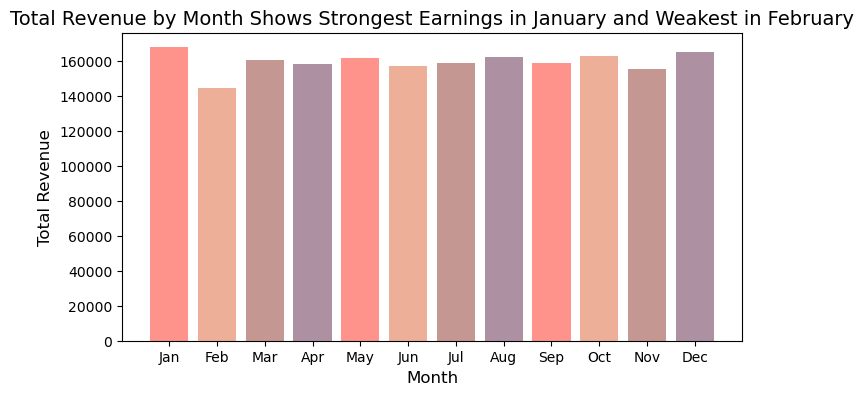

In [13]:
conn = sqlite3.connect('online_sales.db')
query = """
QUERY;
"""
result = pd.read_sql_query(query, conn)

month_names = {
    '01': 'Jan',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Apr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Aug',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'
}
result['month'] = result['month'].map(month_names)

plt.figure(figsize=(8, 4))
plt.bar(result['month'], result['total_revenue'], color=['#fe938c', '#edaf97', '#c49792', '#ad91a3'])
plt.title('Total Revenue by Month Shows Strongest Earnings in January and Weakest in February', fontsize = 14)
plt.xlabel('Month',fontsize = 12)
plt.ylabel('Total Revenue',fontsize = 12)

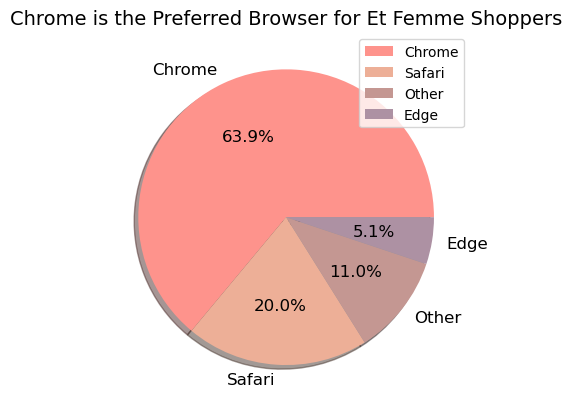

In [40]:
ax = sales['browser'].value_counts(normalize=True).plot(
    kind='pie',
    autopct='%1.1f%%',
    ylabel=' ',
    shadow=True,
    colors=['#fe938c', '#edaf97', '#c49792', '#ad91a3'],
    fontsize=12
)

ax.set_title('Chrome is the Preferred Browser for Et Femme Shoppers', fontsize=14)
ax.legend(loc='upper right')
plt.show()

<font size="6">Question 2</font>

<font size="3">**Question**</font>

<font size="3">Answer</font>

<font size="6"> Question 3 </font>

<font size="3">**Question**</font>

<font size="3">Answer</font>

<font size="6">Conclusion and Recommendations</font>

<font size="3"> Description.</font>

<font size="2">All data for this project was acquired through Kaggle's Database "[Database]"</font>